In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
plt.rcParams['animation.html'] = 'html5'
import numpy as np
import scipy as sp
import scipy.integrate
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from spectral import *
np.set_printoptions(linewidth=120)

In [64]:
L, R = 1500, 2
mesh_x = Multidomain(Legendre(20), np.linspace(0, L, 31))
mesh_r = Legendre(5, (R, 0), 'Radau')
mesh_phi = Fourier(5)
mesh = mesh_x*mesh_r*mesh_phi

rho = 1.06; young = 3.7; nu = 0.34; l = -18.9; m = -13.3; n = -10.0 # PS
#nlc = 1
#l *= nlc; m *= nlc; n *= nlc
#rho = 8.4; young = 110; nu = 0.34 # brass
lam = young*nu/(1 + nu)/(1 - 2*nu)
mu = young/2/(1 + nu)

In [4]:
def cauchy_green(u):
    deform = u.grad(coord='cylindrical')
    return 1/2*(deform + deform.T + deform@deform.T)

def kin_energy(v):
    return rho*(v@v).int(coord='cylindrical')/2

def pot_energy(u):
    CG = cauchy_green(u)
    I1 = CG.trace()
    I2 = 1/2*(CG.trace()**2 - (CG@CG.T).trace())
    I3 = CG.det()
    pot = (lam/2 + mu)*I1**2 - 2*mu*I2 + (l + 2*m)/3*I1**3 - 2*m*I1*I2 + n*I3
    return pot.int(coord='cylindrical')

def energy(u, v):
    return kin_energy(v) + pot_energy(u)

In [5]:
def compress(u, v):
    return np.stack((u.func, v.func)).ravel()

def decompress(y):
    func_u, func_v = y.reshape(2, 3, *mesh.shape)
    u = TensorField(mesh, func_u)
    v = TensorField(mesh, func_v)
    return u, v

def derivative(t, y):
    u, v = decompress(y)
    du_dt = v
    
    CG = cauchy_green(u)
    I1 = CG.trace()
    I2 = 1/2*(CG.trace()**2 - (CG@CG.T).trace())
    dI1 = np.eye(3)
    dI2 = dI1*CG.trace() - CG
    dI3 = CG.cofactor_matrix()
    
    PK = ((lam + 2*mu)*I1*dI1 - 2*mu*dI2 + (l + 2*m)*I1**2*dI1 
          - 2*m*(dI1*I2 + I1*dI2) + n*dI3)@(np.eye(3) + u.grad(coord='cylindrical'))
    
    bval = (f(t), 0), (0, 0), (0, 0)
    F = PK.div(bval, coord='cylindrical')
    F = F.match_domains()  
    
    dv_dt = F/rho
    
    return compress(du_dt, dv_dt)

# Check energy conservation 

In [31]:
np.max(np.random.randn(3, *mesh.shape))

4.069439523591733

In [69]:
t0 = 0
t_max = 10.0
dt = 0.1
T = np.arange(t0, t_max + dt/2, dt)
u0 = TensorField(mesh, 5e-4*np.random.randn(3, *mesh.shape))
v0 = TensorField(mesh, 0*np.random.randn(3, *mesh.shape))

U = TensorField(mesh, np.zeros((len(T), 3) + mesh.shape))
V = TensorField(mesh, np.zeros((len(T), 3) + mesh.shape))
E = np.zeros(len(T))

def f(t):
    return 0

In [70]:
r = sp.integrate.ode(derivative).set_integrator('dop853', rtol=1e-10, atol=1e-10, nsteps=1e4)
r.set_initial_value(compress(u0, v0), t=t0)
for k, t in enumerate(Progress(T)):
    if t > r.t:
        r.integrate(t)
    U[k], V[k] = decompress(r.y)
    E[k] = energy(U[k], V[k])

HTML(value='')

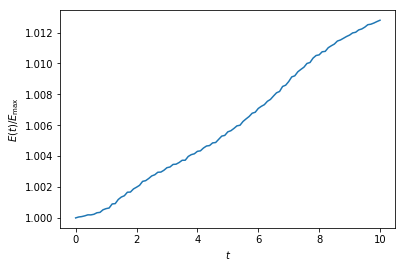

In [73]:
plt.plot(T, E.real/E.real.max())
plt.xlabel(r'$t$')
plt.ylabel(r'$E(t)/E_{\rm max}$')
plt.savefig('energy.png')
plt.show()

# Boundary impact 

In [74]:
%%time
tau = 2
t0 = -8*tau
t_max = 660.0
dt = 3.0
T = np.arange(t0, t_max + dt/2, dt)
u0 = TensorField(mesh, np.zeros((3,) + mesh.shape))
v0 = TensorField(mesh, np.zeros((3,) + mesh.shape))

U = TensorField(mesh, np.zeros((len(T), 3) + mesh.shape))
V = TensorField(mesh, np.zeros((len(T), 3) + mesh.shape))
E = np.zeros(len(T))

def f(t):
    F = 2e-1*np.exp(-t**2/2/tau**2), 0, 0
    return np.asarray(F)[:,None,None]

r = sp.integrate.ode(derivative).set_integrator('dop853', rtol=1e-10, atol=1e-10, nsteps=1e4)
r.set_initial_value(compress(u0, v0), t=t0)
for k, t in enumerate(Progress(T)):
    if t > r.t:
        r.integrate(t)
    U[k], V[k] = decompress(r.y)
    E[k] = energy(U[k], V[k])

HTML(value='')

KeyboardInterrupt: 

In [67]:
fig, ax = plt.subplots()
plt.xlim(0, L)
plt.ylim(-5e-2/4, 5e-2/2)
line, = ax.plot([], [])
time_template = 'time = %.1f'
time_text = ax.text(0.75, 0.9, '', transform=ax.transAxes)
plt.xlabel(r'$x$')
plt.ylabel(r'$U_x(x, 0, 0)$')
plt.close()

def animate(k):
    u = -U[k, 0](None, 0, 0).diff()
    x = np.linspace(0, L, 300)
    line.set_data(x, u(x))
    time_text.set_text(time_template % T[k])
    return line, time_text

anim = animation.FuncAnimation(fig, animate, 
                               frames=len(T), interval=50, blit=True)

In [68]:
anim